## Capstone 1 
# San Francisco Bay Water Quality

ref. [Water quality of SF Bay home page](https://sfbay.wr.usgs.gov/access/wqdata/index.html)
     


## Unit 8 - Statistics

Based on your dataset, the questions that interest you, and the results of the visualization techniques that you used previously, you should choose the most relevant statistical inference techniques. You aren’t expected to demonstrate all of them. You may find yourself revisiting the analytical framework that you first used to develop your proposal questions. It’s fine to refine your questions more as you get deeper into your data and find interesting patterns and answers. 

Think of the following questions and apply them to your dataset:

   * Are there variables that are particularly significant in terms of explaining the answer to your project question?
   * Are there significant differences between subgroups in your data that may be relevant to your project aim?
   * Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?
   * What are the most appropriate tests to use to analyze these relationships?

Ideas:

   1. Mean salinity: I know that salinity is very low where the Sacramento River meets the Bay and highest at the Golden Gate where the Bay meets the ocean, but how does mean salinity compare between stations south of the Gate? They're similar; are they the same?<br>
   <br>

   2. Similarly, how does mean temperature compare between station groups?
   <br>
   
   3. Correlation between pytoplanton biovolume and 
      * chlorophyll or oxygen (guess: positive as chlorophyll produces O2)
      * nutrients (guess: negative as phytoplankton consume nutrients)
   
   <br>
   
   4. Correlation between Sigmat-t (density) and 
      * Salinity (should be positive by definition)
      * Temperature (should be negative by definition)

## Data 

#### Files
   1. `SFBayWaterQuality.csv` - all water quality parameters
   2. `SFBayWaterQualityNutrientData.csv` - only nutrient data samples
   3. `water_quality_units.json` - units dictionary
   4. `SFBayStationLocations.csv` - sampling location information
   5. `station_stats.json` - by-station statistics
   5. `Phytoplankton.csv` - phytoplankton information


## Sampling stations

[Map](https://batchgeo.com/map/68e8afb69e93ec948b457d57c0589742) of sampling stations. Distance from station 36 has been computed. Additional details can be seen in the [interactive map](https://batchgeo.com/map/68e8afb69e93ec948b457d57c0589742).

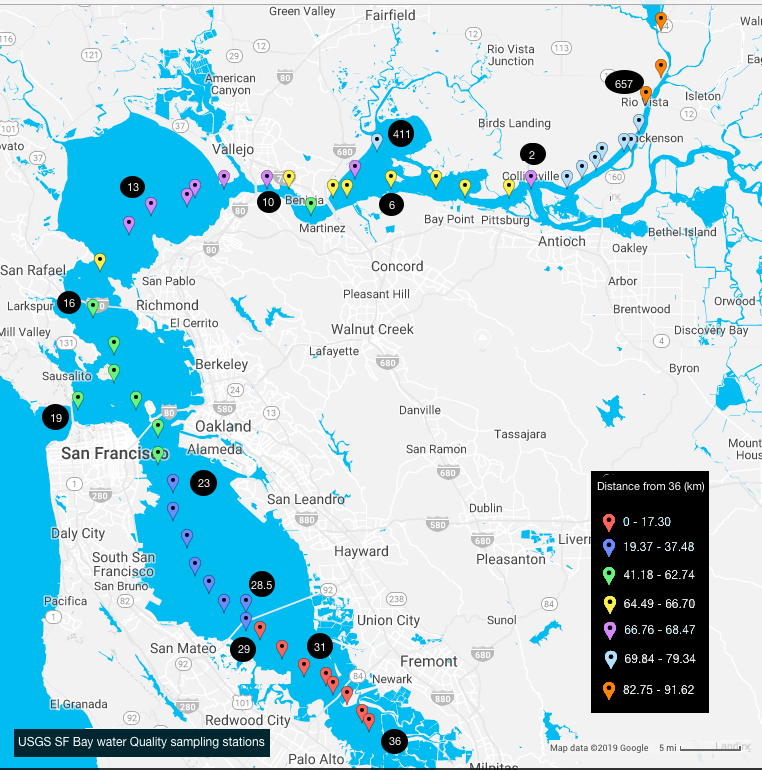
(built using [BatchGeo](https://batchgeo.com))

## Setup


In [1]:
# Import libraries

import json

import numpy as np
import pandas as pd

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


## Read in the data

In [2]:
# Read in the Water Quality data
wq_df = pd.read_csv('Data/SFBayWaterQualityPlus.csv', 
                    header=0, 
                    parse_dates=['DateTime', 'Date'],
                    dtype={'Station' : str}
                    )

# The sampling stations, in geographical order 
# from the Sacramento River south to San Jose

with open('Data/station_list.json', 'r') as fp:
    station_list = json.load(fp)

# Stations are actually categories
wq_df['Station'] = pd.Categorical(wq_df['Station'],
                                  categories=station_list
                                 )

# Dictionary of Water Quality parameters and units
with open('Data/water_quality_units.json', 'r') as f:
    wq_units = json.load(f)

wq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237061 entries, 0 to 237060
Data columns (total 23 columns):
Date                                 237061 non-null datetime64[ns]
Station                              237061 non-null category
Depth                                237061 non-null float64
DateTime                             237061 non-null datetime64[ns]
Distance from 36                     236597 non-null float64
Chlorophyll a/a+PHA                  12895 non-null float64
Fluorescence                         220308 non-null float64
Calculated Chlorophyll               225275 non-null float64
Oxygen Electrode Output              189908 non-null float64
Oxygen Saturation %                  191606 non-null float64
Calculated Oxygen                    188107 non-null float64
Calculated SPM                       200937 non-null float64
Measured Extinction Coefficient      13987 non-null float64
Calculated Extinction Coefficient    4772 non-null float64
Salinity                

In [3]:
# Group stations. Based on the map, we'll choose groups of 8.
i = 0
g = 0
group = {}
s = list(reversed(station_list))
while (i <= len(s)):
    group[g] = s[i:i+8]
    g += 1
    i += 8

print(group)

{0: ['36', '35', '34', '33', '32', '31', '30', '29.5'], 1: ['29', '28.5', '28', '27', '26', '25', '24', '23'], 2: ['22', '21', '20', '19', '18', '17', '16', '15'], 3: ['14', '13', '12.5', '12', '11', '10', '9', '8'], 4: ['405', '7', '6', '5', '411', '407', '4', '3'], 5: ['2', '649', '650', '651', '652', '653', '654', '655'], 6: ['657', '659', '662']}


In [4]:
st_group_names = {
    6: 'Upper Sacramento River',
    5: 'Lower Sacramento River',
    4: 'Suisun Bay',
    3: 'San Pablo Bay',
    2: 'Central Bay (Golden Gate)',
    1: 'South Bay (San Mateo County)',
    0: 'South Bay (Santa Clara County)'
}

In [5]:
# Extract a DataFrame for each station group, so we can easily reference
# only one group at a time.
i=0
st_groups = {}
while (i < len(group)):
    st_groups[i] = wq_df[wq_df['Station'].isin(group[i])]
    i += 1
    

In [6]:
st_groups[0].sample(5)

,Date,Station,Depth,DateTime,Distance from 36,Chlorophyll a/a+PHA,Fluorescence,Calculated Chlorophyll,Oxygen Electrode Output,Oxygen Saturation %,...,Calculated Extinction Coefficient,Salinity,Temperature,Sigma-t,Nitrite,Nitrate + Nitrite,Ammonium,Phosphate,Silicate,Biovolume
169714,2011-02-09,33,9.0,2011-02-09 06:56:00,6.81,NaN,0.51,7.7,9.0,95.0,...,NaN,21.50,12.00,16.13,NaN,NaN,NaN,NaN,NaN,NaN
64672,1996-02-01,30,15.0,1996-02-01 11:56:00,14.75,NaN,0.34,0.8,8.0,92.0,...,NaN,23.95,11.43,18.12,NaN,NaN,NaN,NaN,NaN,NaN
131253,2006-02-21,34,1.0,2006-02-21 08:50:00,3.53,NaN,3.98,58.0,10.9,102.0,...,NaN,14.99,9.88,11.39,NaN,NaN,NaN,NaN,NaN,NaN
233248,2018-12-14,32,5.0,2018-12-14 08:42:00,8.15,NaN,0.23,3.3,7.3,84.0,...,NaN,29.69,12.88,22.30,NaN,NaN,NaN,NaN,NaN,NaN
74200,1997-04-01,34,3.0,1997-04-01 06:47:00,3.53,NaN,1.80,18.6,8.5,91.0,...,NaN,20.48,15.08,14.79,NaN,NaN,NaN,NaN,NaN,NaN


<hr style="border: 3px solid green;">

## Salinity 

I know that salinity is very low where the Sacramento River meets the Bay and highest at the Golden Gate where the Bay meets the ocean, but how does salinity compare between stations south of the Gate? They're similar; are they the same?

_Null Hypothesis:_ Mean salinity is essentially the same for the stations nearest the Golden Gate and to the south.

_Alternative Hypothesis:_ Mean salinity differs between the station groups at the Golden Gate, in San Mateo County, and Santa Clara county.

Calculate mean salinity and plot salinity for station groups 0 - 4.

In [7]:
means = {}
for i in range(5):
    means[i] = st_groups[i]['Salinity'].dropna().mean()
    print("the mean salinity for group", i, "is",  means[i])


the mean salinity for group 0 is 24.784078166476036
the mean salinity for group 1 is 26.455936753624258
the mean salinity for group 2 is 28.05572708826513
the mean salinity for group 3 is 17.306090109429814
the mean salinity for group 4 is 5.776422359670744


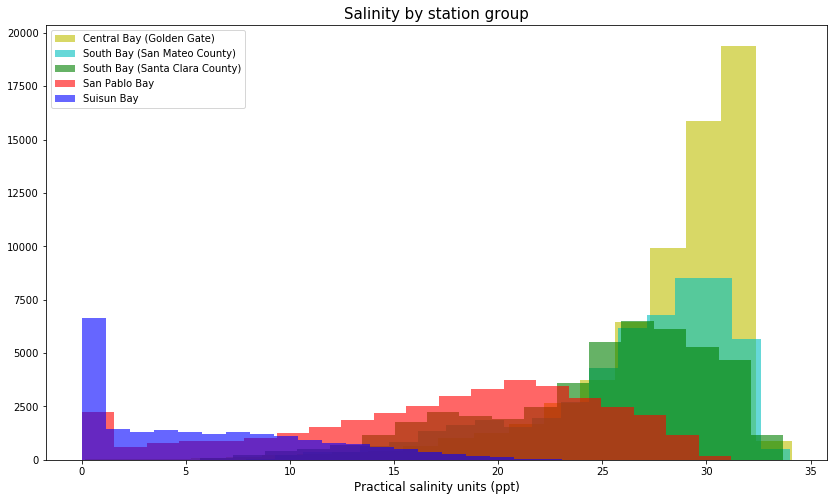

In [8]:
fig, ax0 = plt.subplots(figsize=(14,8))
kwargs = dict(bins=20, alpha=0.6,)
_ = plt.hist(st_groups[2]['Salinity'].dropna(), label=st_group_names[2], color='y', **kwargs)
_ = plt.hist(st_groups[1]['Salinity'].dropna(), label=st_group_names[1], color='c', **kwargs)
_ = plt.hist(st_groups[0]['Salinity'].dropna(), label=st_group_names[0], color='g', **kwargs)
_ = plt.hist(st_groups[3]['Salinity'].dropna(), label=st_group_names[3], color='r', **kwargs)
_ = plt.hist(st_groups[4]['Salinity'].dropna(), label=st_group_names[4], color='b', **kwargs)

_ = plt.xlabel("Practical salinity units (ppt)", fontsize=12)
_ = plt.title("Salinity by station group", fontsize=15)

plt.legend(prop={'size': 10})

plt.show()


Stations north of the Gate are much lower than I thought.

Let's just look at the group of stations near the Golden Gate and the two groups to the south.

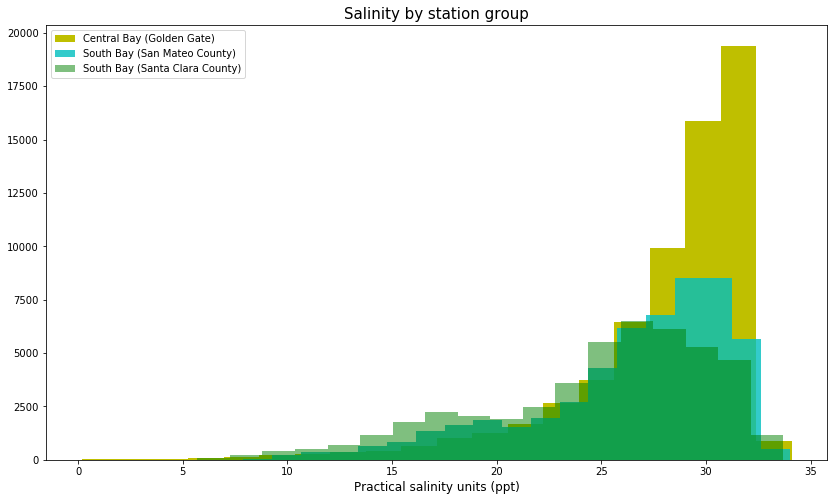

In [9]:
fig, ax0 = plt.subplots(figsize=(14,8))
kwargs = dict(bins=20)
_ = plt.hist(st_groups[2]['Salinity'].dropna(), label=st_group_names[2], color='y', **kwargs)
_ = plt.hist(st_groups[1]['Salinity'].dropna(), label=st_group_names[1], color='c', alpha=0.8, **kwargs)
_ = plt.hist(st_groups[0]['Salinity'].dropna(), label=st_group_names[0], color='g', alpha=0.5, **kwargs)

_ = plt.xlabel("Practical salinity units (ppt)",fontsize=12)
_ = plt.title('Salinity by station group',fontsize=15)

plt.legend(prop={'size': 10})

plt.show()


What is the mean salinity for each group of stations in this part of the Bay?

In [10]:
means = {}
for i in range(3):
    means[i] = st_groups[i]['Salinity'].dropna().mean()
    print("The mean salinity for group", i, st_group_names[i], "is",  means[i])


The mean salinity for group 0 South Bay (Santa Clara County) is 24.784078166476036
The mean salinity for group 1 South Bay (San Mateo County) is 26.455936753624258
The mean salinity for group 2 Central Bay (Golden Gate) is 28.05572708826513


The means are close. Is the closeness statistically significant?

### T-test

<blockquote>
    
_The t test (also called Student’s T Test) compares two averages (means) and tells you if they are different from each other. The t test also tells you how significant the differences are; in other words, it lets you know if those differences could have happened by chance._ ([ref](https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f))

[T-test example reference](https://pythonfordatascience.org/independent-t-test-python/)
</blockquote>

If p-value is less than the predetermined value of significance, reject the null hypothesis and accept the alternative hypothesis.

Null hypothesis: There is no difference in the mean salinity between:
   * station groups 1 and 2
   * station groups 0 and 1
   
Alternative Hypothesis: There is a significant difference in the mean salinity between:
   * station groups 1 and 2
   * station groups 0 and 1

**1. Check for Normality & Variance criteria**
<blockquote>
The first step is to check the normality and variance criteria.

### **Normality**

To test for normality, apply the Shapiro-Wilk test by calling the `scipy stats.shapiro()` method.
This control tests the null hypothesis that the data was drawn from a normal distribution and returns the test statistic ('W') and the probability ('p').
The normality criterion holds true when p > alpha (where alpha is the probability threshold, usually set to 0.05).

Important: be sure to call the `dropna()` method on the data set to drop NaN values during testing.<br>

[ref: PytoLearn](http://pytolearn.csd.auth.gr/d1-hyptest/12/ttest-indep.html)
</blockquote>

### **Normal distribution of residuals**

<blockquote>
    
Checking for normality can be done visually or with a formula test. Visually, one can use a p-p plot, a q-q plot, or histogram, and/or one can use the Shapiro-Wilk test to formally test for normality. To test for normality formally, use `stats.shapiro()` which is from the `scipy.stats` library.<br>

[ref: Python for Data Science](https://pythonfordatascience.org/independent-t-test-python/)
</blockquote>


In [11]:
# Shapiro-Wilk normality test for group 0
sw_0 = stats.shapiro(st_groups[0]['Salinity'].dropna())

# Shapiro-Wilk normality test for group 1
sw_1 = stats.shapiro(st_groups[1]['Salinity'].dropna())

# Shapiro-Wilk normality test for group 2
sw_2 = stats.shapiro(st_groups[2]['Salinity'].dropna())

print("Shapiro-Wilk result for station group 0,", st_group_names[0], "\n", sw_0)
print("Shapiro-Wilk result for station group 1,", st_group_names[1], "\n", sw_1)
print("Shapiro-Wilk result for station group 2,", st_group_names[2], "\n", sw_2)

Shapiro-Wilk result for station group 0, South Bay (Santa Clara County) 
 (0.9334824085235596, 0.0)
Shapiro-Wilk result for station group 1, South Bay (San Mateo County) 
 (0.8940597772598267, 0.0)
Shapiro-Wilk result for station group 2, Central Bay (Golden Gate) 
 (0.7928236722946167, 0.0)


/Local/Users/vlb/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The distributions are not normal, but "p-value may not be accurate for N > 5000".

We can also check for normality a different way, using a probability plot.

```
scipy.stats.probplot
Calculate quantiles for a probability plot, and optionally show the plot.
```

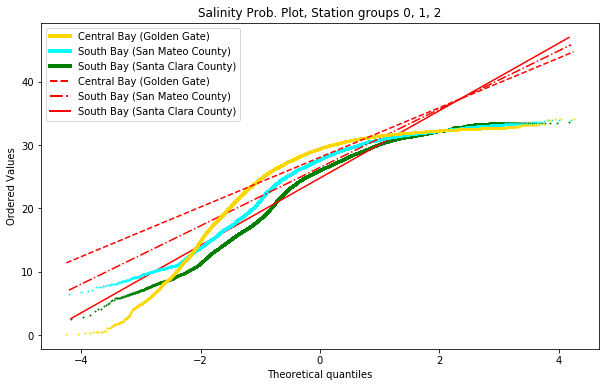

In [12]:
# Probability plots for three station groups on the same chart

fig, ax = plt.subplots(figsize=(10,6), sharey=True)
stats.probplot(st_groups[0]['Salinity'].dropna(), plot=ax)
stats.probplot(st_groups[1]['Salinity'].dropna(), plot=ax)
stats.probplot(st_groups[2]['Salinity'].dropna(), plot=ax)

ax.get_lines()[0].set_markerfacecolor('green')
ax.get_lines()[0].set_markeredgecolor('green')
ax.get_lines()[0].set_marker('.')
ax.get_lines()[0].set_markersize('2')

ax.get_lines()[1].set_linestyle('-')

ax.get_lines()[2].set_markerfacecolor('cyan')
ax.get_lines()[2].set_markeredgecolor('cyan')
ax.get_lines()[2].set_marker('.')
ax.get_lines()[2].set_markersize('2')

ax.get_lines()[3].set_linestyle('-.')

ax.get_lines()[4].set_markerfacecolor('gold')
ax.get_lines()[4].set_markeredgecolor('gold')
ax.get_lines()[4].set_marker('.')
ax.get_lines()[4].set_markersize('2')

ax.get_lines()[5].set_linestyle('--')

colors = [ 'gold', 'cyan', 'green']
lines1 = [Line2D([0], [0], color=c, linewidth=4, linestyle='-') for c in colors]
lines2 = [Line2D([0], [0], color='r', linewidth=2, linestyle='--'),
          Line2D([0], [0], color='r', linewidth=2, linestyle='-.'),
          Line2D([0], [0], color='r', linewidth=2, linestyle='-')
         ]

lines = lines1 + lines2
labels = [st_group_names[2], st_group_names[1], st_group_names[0],
          st_group_names[2], st_group_names[1], st_group_names[0]]
ax.legend(lines, labels, loc="upper left")


plt.title('Salinity Prob. Plot, Station groups 0, 1, 2') 
plt.show()

Yep. Not normal. (I didn't think they were. They all have a tail off to the left.)

Let's keep going and see where we end up.

**Variance**

<blockquote>
    
To test for variance, apply the Levene test by calling the scipy `stats.levene()` method
This control tests tests the null hypothesis that all samples come from populations with equal variances. It returns the test statistic ('W') and the probability ('p').
The variance criterion holds true when p > alpha (where alpha is the probability threshold usually set to 0.05)

[ref: PytoLearn](http://pytolearn.csd.auth.gr/d1-hyptest/12/ttest-indep.html)

</blockquote>

Note:
<blockquote>
Three variations of Levene’s test are possible. The possibilities and their recommended usages are:

   * ‘mean’ -
   Recommended for symmetric, moderate-tailed distributions

   * ‘median’ -
   Recommended for skewed (non-normal) distributions

   * ‘trimmed’ -
   Recommended for heavy-tailed distributions
   
   [ref: scipy docs](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html)
</blockquote>
The default is ‘median’. 

We don't have normal distributions, so we'll try both `median` and `trimmed`.



In [13]:
# Levene tests between station groups 2 and 1
lev_2_1_m = stats.levene(st_groups[2]['Salinity'].dropna(), 
                         st_groups[1]['Salinity'].dropna(), 
                         center='median')
lev_2_1_t = stats.levene(st_groups[2]['Salinity'].dropna(), 
                         st_groups[1]['Salinity'].dropna(), 
                         center='trimmed')

print("Levene result for station group 2,", st_group_names[2], 
      "\n\tvs group 1,", st_group_names[1])
print("median:\n", lev_2_1_m, "\ntrimmed\n", lev_2_1_t)

print("")

# Levene tests between station groups 1 and 0
lev_1_0_m = stats.levene(st_groups[1]['Salinity'].dropna(), 
                         st_groups[0]['Salinity'].dropna(), 
                         center='median')
lev_1_0_t = stats.levene(st_groups[1]['Salinity'].dropna(), 
                         st_groups[0]['Salinity'].dropna(), 
                         center='trimmed')

print("Levene result for station group 1,", st_group_names[1], 
      "\n\tvs group 0,", st_group_names[0])
print("median:\n", lev_1_0_m, "\ntrimmed\n", lev_1_0_t)


Levene result for station group 2, Central Bay (Golden Gate) 
	vs group 1, South Bay (San Mateo County)
median:
 LeveneResult(statistic=1233.9270599281986, pvalue=6.212186164025708e-269) 
trimmed
 LeveneResult(statistic=3531.3928196383067, pvalue=0.0)

Levene result for station group 1, South Bay (San Mateo County) 
	vs group 0, South Bay (Santa Clara County)
median:
 LeveneResult(statistic=737.9652460182751, pvalue=6.429550916590033e-162) 
trimmed
 LeveneResult(statistic=1199.1171405669688, pvalue=4.93712551633467e-261)


p << 0.05

The variances are not homogeneous.

We'll need to pass `equal_var=False` to `stats.ttest_ind`

In [14]:
# t-test between station groups 2 and 1

t_2_1, p_2_1 = stats.ttest_ind(st_groups[2]['Salinity'].dropna(), 
                               st_groups[1]['Salinity'].dropna(), 
                               equal_var=False)


print("T-test result for station group 2,", st_group_names[2], 
      "\n\tvs group 1,", st_group_names[1])
print(t_2_1, "\np:", p_2_1)
print("")

# t-test between station groups 1 and 0

t_1_0, p_1_0 = stats.ttest_ind(st_groups[1]['Salinity'].dropna(), 
                               st_groups[0]['Salinity'].dropna(), 
                               equal_var=False)

print("T-test result for station group 1,", st_group_names[1], 
      "\n\tvs group 0,", st_group_names[0])
print(t_1_0, "\np:", p_1_0)


T-test result for station group 2, Central Bay (Golden Gate) 
	vs group 1, South Bay (San Mateo County)
58.941584001098654 
p: 0.0

T-test result for station group 1, South Bay (San Mateo County) 
	vs group 0, South Bay (Santa Clara County)
50.57729469105698 
p: 0.0


Interpretation of the results

Since p < alpha (0.05) in both cases, we can say that the null hypothesis is rejected and suggest that there is a difference in the mean salinity between these groups of stations.

<hr style="border: 3px solid green;">

## Temperature

_Null Hypothesis:_ Mean temperature is essentially the same throughout the Bay.

_Alternative Hypothesis:_ Mean temperature differs between station groups.



Calculate the mean temperature for each station group.

In [15]:
means = {}
for i in range(5):
    means[i] = st_groups[i]['Temperature'].dropna().mean()
    print("The mean temperature for group", i, st_group_names[i], "is",  means[i])


The mean temperature for group 0 South Bay (Santa Clara County) is 16.355256894679698
The mean temperature for group 1 South Bay (San Mateo County) is 15.671708822980788
The mean temperature for group 2 Central Bay (Golden Gate) is 14.361755786359295
The mean temperature for group 3 San Pablo Bay is 15.673822936044228
The mean temperature for group 4 Suisun Bay is 16.199174563359346


They look similar.

Now plot temperature for each group.

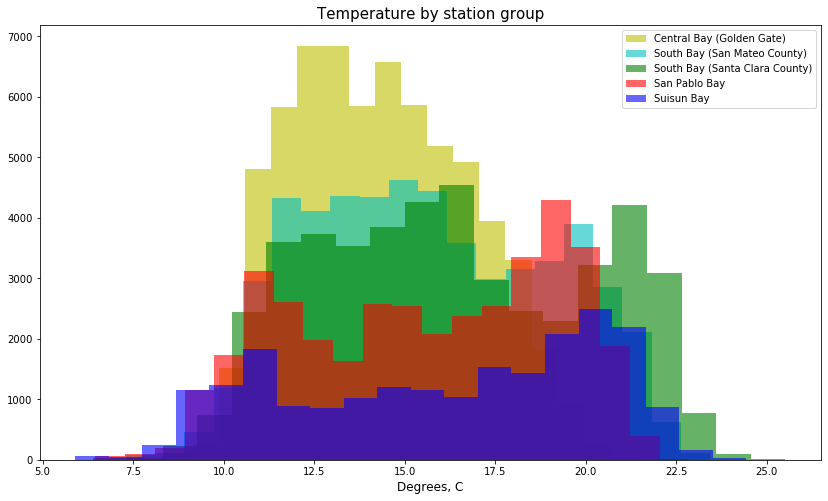

In [16]:
fig, ax0 = plt.subplots(figsize=(14,8))
kwargs = dict(bins=20, alpha=0.6,)
_ = plt.hist(st_groups[2]['Temperature'].dropna(), label=st_group_names[2], color='y', **kwargs)
_ = plt.hist(st_groups[1]['Temperature'].dropna(), label=st_group_names[1], color='c', **kwargs)
_ = plt.hist(st_groups[0]['Temperature'].dropna(), label=st_group_names[0], color='g', **kwargs)
_ = plt.hist(st_groups[3]['Temperature'].dropna(), label=st_group_names[3], color='r', **kwargs)
_ = plt.hist(st_groups[4]['Temperature'].dropna(), label=st_group_names[4], color='b', **kwargs)

_ = plt.xlabel("Degrees, C", fontsize=12)
_ = plt.title("Temperature by station group", fontsize=15)

plt.legend(prop={'size': 10})

plt.show()

They overlap. The means could be the same.

Use OneWay ANOVA – Similar to a ttest, except that this test can be used to compare the means from THREE OR MORE groups.

The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

   * The samples are independent.

   * Each sample is from a normally distributed population.

   * The population standard deviations of the groups are all equal. This property is known as homoscedasticity.
   
If these assumptions are not true for a given set of data, it may still be possible to use the Kruskal-Wallis H-test (`scipy.stats.kruskal`) although with some loss of power.

Are the samples normally distributed?

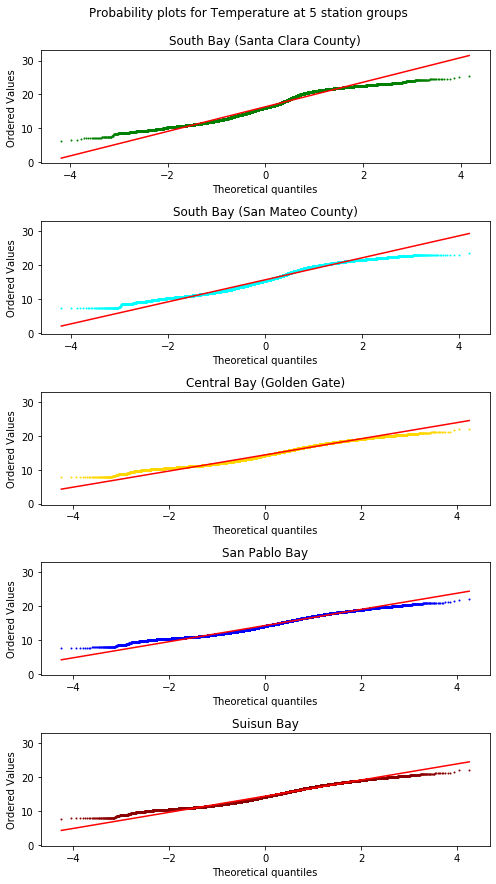

In [17]:
# Probability plots for five station groups

fig, (ax0, ax1, ax2, ax3, ax4)  = plt.subplots(5, sharey=True, figsize=(7, 10))
fig.suptitle("Probability plots for Temperature at 5 station groups", y=1.02)
fig.set_figheight(12)

stats.probplot(st_groups[0]['Temperature'].dropna(), plot=ax0)
stats.probplot(st_groups[1]['Temperature'].dropna(), plot=ax1)
stats.probplot(st_groups[2]['Temperature'].dropna(), plot=ax2)
stats.probplot(st_groups[2]['Temperature'].dropna(), plot=ax3)
stats.probplot(st_groups[2]['Temperature'].dropna(), plot=ax4)

ax0.set_title(st_group_names[0])
ax0.get_lines()[0].set_markerfacecolor('green')
ax0.get_lines()[0].set_markeredgecolor('green')
ax0.get_lines()[0].set_marker('.')
ax0.get_lines()[0].set_markersize('2')

ax1.set_title(st_group_names[1])
ax1.get_lines()[0].set_markerfacecolor('cyan')
ax1.get_lines()[0].set_markeredgecolor('cyan')
ax1.get_lines()[0].set_marker('.')
ax1.get_lines()[0].set_markersize('2')

ax2.set_title(st_group_names[2])
ax2.get_lines()[0].set_markerfacecolor('gold')
ax2.get_lines()[0].set_markeredgecolor('gold')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markersize('2')

ax3.set_title(st_group_names[3])
ax3.get_lines()[0].set_markerfacecolor('blue')
ax3.get_lines()[0].set_markeredgecolor('blue')
ax3.get_lines()[0].set_marker('.')
ax3.get_lines()[0].set_markersize('2')

ax4.set_title(st_group_names[4])
ax4.get_lines()[0].set_markerfacecolor('DARKRED')
ax4.get_lines()[0].set_markeredgecolor('DARKRED')
ax4.get_lines()[0].set_marker('.')
ax4.get_lines()[0].set_markersize('2')


plt.tight_layout()

plt.show()

These appear to be close to normal distributions.

Are the standard deviations of the groups equal?

In [18]:
std_devs = {}
for i in range(5):
    std_devs[i] = st_groups[i]['Temperature'].dropna().std()
    print("the std deviation in temperature for group", i, st_group_names[i], "is",  std_devs[i])


the std deviation in temperature for group 0 South Bay (Santa Clara County) is 3.688712735672181
the std deviation in temperature for group 1 South Bay (San Mateo County) is 3.2864580083495354
the std deviation in temperature for group 2 Central Bay (Golden Gate) is 2.402515344395306
the std deviation in temperature for group 3 San Pablo Bay is 3.5440968368424817
the std deviation in temperature for group 4 Suisun Bay is 4.187827429034062


The std. deviations do not appear to be equal.

However, "if group sizes are equal, the F-statistic is robust to violation of the equal standard deviations requirement", so we can continue.

In [19]:
counts = {}
for i in range(5):
    counts[i] = st_groups[i]['Temperature'].dropna().count()
    print("The number of temperature samples for group", i, st_group_names[i], "is",  counts[i])


The number of temperature samples for group 0 South Bay (Santa Clara County) is 46050
The number of temperature samples for group 1 South Bay (San Mateo County) is 53610
The number of temperature samples for group 2 Central Bay (Golden Gate) is 64894
The number of temperature samples for group 3 San Pablo Bay is 38167
The number of temperature samples for group 4 Suisun Bay is 21528


My guess is that group sizes are not sufficiently equal.

I'll try the Kruskal-Wallis H-test instead. "The Kruskal-Wallis test is a nonparametric (distribution free) test, and is used when the assumptions of one-way ANOVA are not met."

In [20]:
means = {}
for i in range(5):
    means[i] = st_groups[i]['Temperature'].dropna().mean()
    print("The mean temperature for group", i, st_group_names[i], "is",  means[i])


The mean temperature for group 0 South Bay (Santa Clara County) is 16.355256894679698
The mean temperature for group 1 South Bay (San Mateo County) is 15.671708822980788
The mean temperature for group 2 Central Bay (Golden Gate) is 14.361755786359295
The mean temperature for group 3 San Pablo Bay is 15.673822936044228
The mean temperature for group 4 Suisun Bay is 16.199174563359346


In [21]:
# Kruskal-Wallis H-test for temperatur difference among 5 station groups
print("Kruskal-Wallis H-test result for station groups 0-4: ")
stats.kruskal(st_groups[0]['Temperature'].dropna(), 
              st_groups[1]['Temperature'].dropna(),
              st_groups[2]['Temperature'].dropna(),
              st_groups[3]['Temperature'].dropna(),
              st_groups[4]['Temperature'].dropna()
             )

Kruskal-Wallis H-test result for station groups 0-4: 


KruskalResult(statistic=10368.357869745143, pvalue=0.0)

If the p-value is less than 0.05, we reject the null hypothesis that there's no difference between the means and conclude that a significant difference does exist. 

There is a significant difference, but the test does not tell us where the difference is.

I will guess that it is station group 2 (14.36 degrees)

In [22]:
# Kruskal-Wallis H-test for temperature difference between station groups 0, 1, 3, and 4

print("Kruskal-Wallis H-test result for station groups 0, 1, 3, and 4:")
stats.kruskal(st_groups[0]['Temperature'].dropna(), 
              st_groups[1]['Temperature'].dropna(),
              st_groups[3]['Temperature'].dropna(),
              st_groups[4]['Temperature'].dropna()
             )

Kruskal-Wallis H-test result for station groups 0, 1, 3, and 4:


KruskalResult(statistic=1213.3558337027168, pvalue=9.277267059747471e-263)

The p-value is still less than 0.05,


In [23]:
# Kruskal-Wallis H-test for temperature difference between station groups 1 and 3

print("Kruskal-Wallis H-test result for station group 1", st_group_names[1],
      "\nand station group 3", st_group_names[3])
stats.kruskal(st_groups[1]['Temperature'].dropna(),
              st_groups[3]['Temperature'].dropna()
             )

Kruskal-Wallis H-test result for station group 1 South Bay (San Mateo County) 
and station group 3 San Pablo Bay


KruskalResult(statistic=3.2206275602444854, pvalue=0.07271574735319238)

The p-value (0.073) is greater than 0.05; we cannot reject the null hypothesis that there's no difference between the means. We conclude that no significant difference in mean temperature exists between station groups 1 and 3.

<hr style="border: 3px solid green;">

## Are any features correlated?

There might (should?) be a correlation between one or more of the following:
   * phytoplankton biovolume and chlorophyll
   * chlorophyll and oxygen 
   * depth and temperature


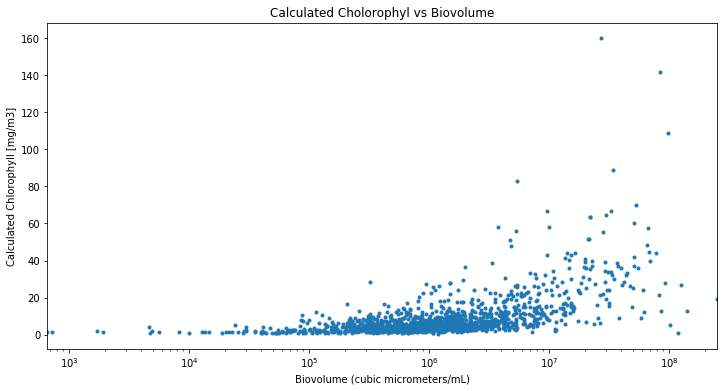

In [24]:
# Is there a correlation between phytoplankton biovolume and chlorophyll?

chlor_df = wq_df[(wq_df['Calculated Chlorophyll'].notnull()) & 
                (wq_df['Biovolume'].notnull())
               ]
ax = chlor_df.plot(y='Calculated Chlorophyll', x='Biovolume', 
                  figsize=(12,6), linestyle='none', marker='.', 
                  logx=True, legend=False)

ylabel='Calculated Chlorophyll' + ' ' + wq_units['Calculated Chlorophyll']
ax.set_ylabel(ylabel)

xlabel='Biovolume' + ' ' + wq_units['Biovolume']
ax.set_xlabel(xlabel)

plt.title('Calculated Cholorophyl vs Biovolume') 

plt.show()


In [25]:
data1 = chlor_df['Biovolume']
data2 = chlor_df['Calculated Chlorophyll']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[1.81824116e+14 7.57515452e+07]
 [7.57515452e+07 1.36247317e+02]]

Pearsons correlation: 0.481

Spearmans correlation: 0.607


There is a positive correlation between Biovolume and Chlorophyll.

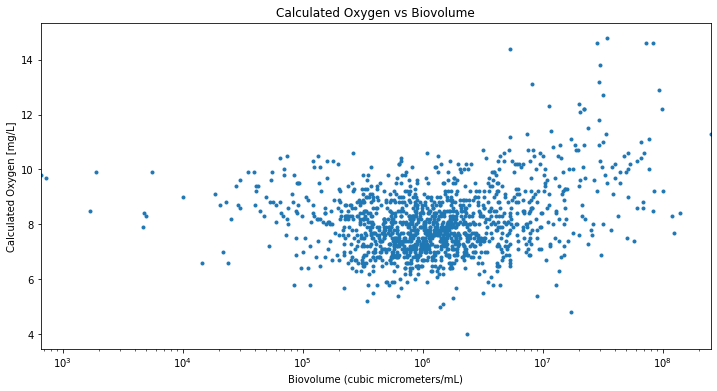

In [26]:
# Is there a correlation between phytoplankton biovolume and oxygen?

o2b_df = wq_df[(wq_df['Biovolume'].notnull()) & 
                (wq_df['Calculated Oxygen'].notnull())
               ]

ax = o2b_df.plot(y='Calculated Oxygen', x='Biovolume', 
                figsize=(12,6), linestyle='none', marker='.', 
                legend=False, logx=True, )

xlabel='Biovolume' + ' ' + wq_units['Biovolume']
ax.set_xlabel(xlabel)

ylabel='Calculated Oxygen' + ' ' + wq_units['Calculated Oxygen']
ax.set_ylabel(ylabel)

plt.title('Calculated Oxygen vs Biovolume') 

plt.show()


In [27]:
data1 = o2b_df['Biovolume']
data2 = o2b_df['Calculated Oxygen']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[1.92898412e+14 5.76929737e+06]
 [5.76929737e+06 1.55496008e+00]]

Pearsons correlation: 0.333

Spearmans correlation: 0.161


There is a weak positive correlation between Biovolume and Oxygen.

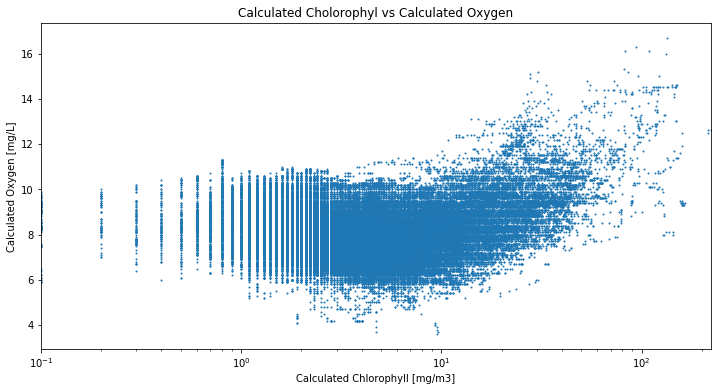

In [28]:
# Is there a correlation between chlorophyll and oxygen?

o2chlor_df = wq_df[(wq_df['Calculated Chlorophyll'].notnull()) & 
                (wq_df['Calculated Oxygen'].notnull())
               ]

ax = o2chlor_df.plot(y='Calculated Oxygen', x='Calculated Chlorophyll', 
                figsize=(12,6), linestyle='none', marker='.', 
                legend=False, logx=True )
ax.get_lines()[0].set_markersize('2')

xlabel='Calculated Chlorophyll' + ' ' + wq_units['Calculated Chlorophyll']
ax.set_xlabel(xlabel)

ylabel='Calculated Oxygen' + ' ' + wq_units['Calculated Oxygen']
ax.set_ylabel(ylabel)

plt.title('Calculated Cholorophyl vs Calculated Oxygen') 

plt.show()


In [29]:
data1 = o2chlor_df['Calculated Chlorophyll']
data2 = o2chlor_df['Calculated Oxygen']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[53.26027301  2.13119576]
 [ 2.13119576  1.03124445]]

Pearsons correlation: 0.288

Spearmans correlation: -0.101


Pearson says "weak positive" correlation between Chlorophyll and Oxygen. (I expected this to be larger).

Spearman says weak negative correlation.

Apparently, this is OK.

<blockquote>
    The pearson correlation detects [that] there is a general upwards motion in the combined data ... The spearman correlation just sees the ranks...
    
[ref](https://stats.stackexchange.com/questions/219029/what-is-the-explanation-for-having-a-pearsons-correlation-coefficient-significa/)
</blockquote>

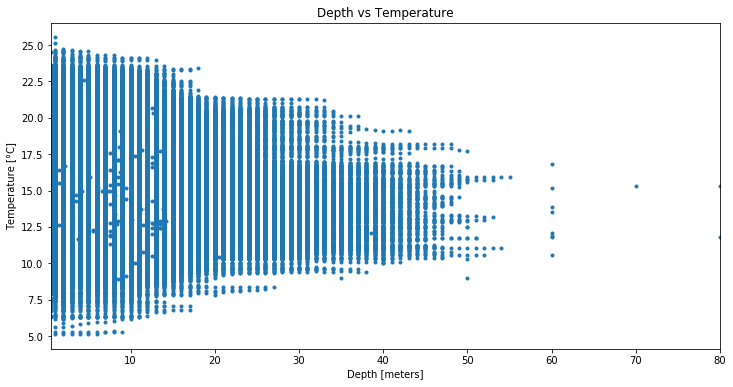

In [30]:
# Is there a correlation between depth and temperature?
    
temp_df = wq_df[(wq_df['Depth'].notnull()) & 
                (wq_df['Temperature'].notnull())
               ]
ax = temp_df.plot(x='Depth', y='Temperature', figsize=(12,6),
                 linestyle='none', marker='.', legend=False)

xlabel='Depth' + ' ' + wq_units['Depth']
ax.set_xlabel(xlabel)

ylabel='Temperature' + ' ' + wq_units['Temperature']
ax.set_ylabel(ylabel)

plt.title('Depth vs Temperature') 

plt.show()


In [31]:
data1 = temp_df['Depth']
data2 = temp_df['Temperature']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[50.29891469 -3.27247875]
 [-3.27247875 11.9102004 ]]

Pearsons correlation: -0.134

Spearmans correlation: -0.114


There is a very weak negative correlation between depth and temperature. (I expected this to be larger).

I also checked for any correlation between depth and suspended particulate matter (not shown). The results indicated no correlation.

<hr style="border: 1px solid green;">

### Nutrients

I checked for a correlation between phyoplankton biovolume and
   * Nitrite
   * Nitrate+Nitrite
   * Phosphate
   * Ammonium
   * Silicate
   
I was surprised to see that any correlation between these was weak. The best, for biovolume vs silicate was 
`Pearsons correlation: -0.308` (shown below).

Perhaps the quantity of dissolved nutrients in the water is sufficiently large that phytoplankon consumption has only a small effect.

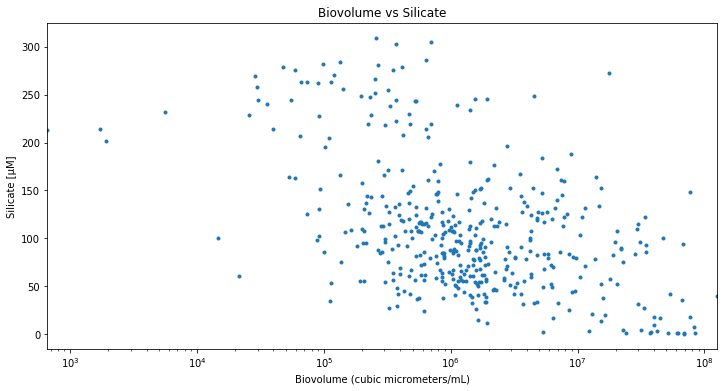

In [32]:
# Is there a correlation between depth and temperature?<hr style="border: 3px solid green;">
nutr5_df = wq_df[(wq_df['Biovolume'].notnull()) & 
                (wq_df['Silicate'].notnull())
               ]
ax = nutr5_df.plot(x='Biovolume', y='Silicate', figsize=(12,6),
            linestyle='none', marker='.', legend=False, logx=True, )

xlabel='Biovolume' + ' ' + wq_units['Biovolume']
ax.set_xlabel(xlabel)

ylabel='Silicate' + ' ' + wq_units['Silicate']
ax.set_ylabel(ylabel)

plt.title('Biovolume vs Silicate') 

plt.show()


In [33]:
data1 = nutr5_df['Biovolume']
data2 = nutr5_df['Silicate']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[ 2.05952317e+14 -2.96703951e+08]
 [-2.96703951e+08  4.51862307e+03]]

Pearsons correlation: -0.308

Spearmans correlation: -0.436


There is a weak negative correlation between Biovolume and Silicate.


<hr style="border: 1px solid green;">

### Sigma-t

Sigma-t is a measure of the density of the water, which is calculated as a function of salinity and temperature. Density increases with increasing salinity and decreasing temperature.

There should be a positive correlation between Sigma-t and salinity. There should be a negative correlation between Sigma-t and temperature. 

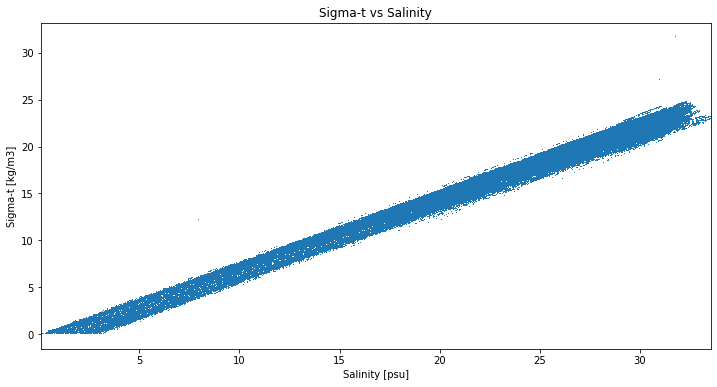

In [34]:
sal_df = wq_df[(wq_df['Sigma-t'].notnull()) & 
                (wq_df['Salinity'].notnull())
               ]
ax = sal_df.plot(x='Salinity',y='Sigma-t',  figsize=(12,6),
            linestyle='none', marker=',', legend=False)

xlabel='Salinity' + ' ' + wq_units['Salinity']
ax.set_xlabel(xlabel)

ylabel='Sigma-t' + ' ' + wq_units['Sigma-t']
ax.set_ylabel(ylabel)

plt.title('Sigma-t vs Salinity') 

plt.show()


In [35]:
data1 = sal_df['Sigma-t']
data2 = sal_df['Salinity']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[35.07370765 45.52421163]
 [45.52421163 59.89455839]]

Pearsons correlation: 0.993

Spearmans correlation: 0.978


There is a very clear correlation between Sigma-t and salinity.

What about temperature?

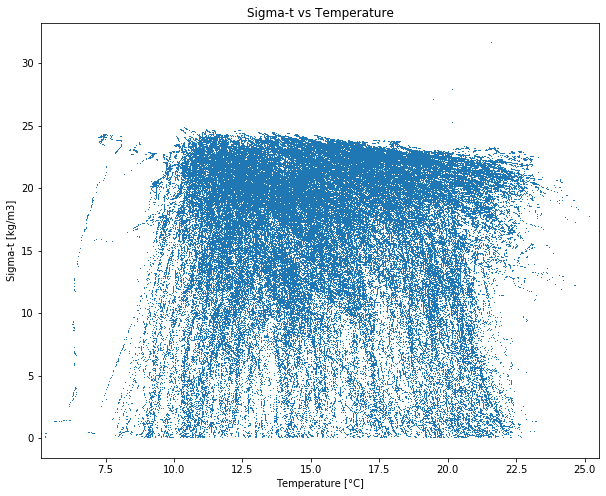

In [36]:
temp_df = wq_df[(wq_df['Sigma-t'].notnull()) & 
                (wq_df['Temperature'].notnull())
               ]
ax = temp_df.plot(x='Temperature', y='Sigma-t',figsize=(10,8),
            linestyle='none', marker=',', legend=False)

xlabel='Temperature' + ' ' + wq_units['Temperature']
ax.set_xlabel(xlabel)

ylabel='Sigma-t' + ' ' + wq_units['Sigma-t']
ax.set_ylabel(ylabel)

plt.title('Sigma-t vs Temperature') 

plt.show()


In [37]:
data1 = temp_df['Sigma-t']
data2 = temp_df['Temperature']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[35.07730818 -0.66416418]
 [-0.66416418 11.20725859]]

Pearsons correlation: -0.033

Spearmans correlation: -0.049


Apparently, the effect of the salinity is greater than the effect of the temperature.

What if we stick to a group of stations with similar salinity and plot both temperature and salinity on the same plot?

In [38]:
def plot_me(group_number, marker):
    """
    Plot Salinity and Temperature vs Sigma-t for the given station group.
    """
    group_df = st_groups[group_number][(st_groups[group_number]['Sigma-t'].notnull()) & 
                       (st_groups[group_number]['Temperature'].notnull()) &
                       (st_groups[group_number]['Salinity'].notnull())
                      ]

    fig, ax1 = plt.subplots(figsize=(12,8))
    ax2 = ax1.twinx()

    group_df.plot(x='Sigma-t',y='Salinity', ax=ax1, color='orange',
             linestyle='none', marker=marker)

    group_df.plot(x='Sigma-t',y='Temperature', ax=ax2,
            linestyle='none', marker=marker)

    xlabel='Sigma-t' + ' ' + wq_units['Sigma-t']
    ax1.set_xlabel(xlabel)

    ylabel1='Salinity' + ' ' + wq_units['Salinity']
    ax1.set_ylabel(ylabel1)
    custom_leg1 = [Line2D([0], [0], marker='o', color='orange')]
    ax1.legend(custom_leg1, ['Salnity'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left")

    ylabel2='Temperature' + ' ' + wq_units['Temperature']
    ax2.set_ylabel(ylabel2)
    custom_leg2 = [Line2D([0], [0], marker='o', color='blue')]
    ax2.legend(custom_leg2, ['Temperature'], bbox_to_anchor=(0.82,1.02,0,0), loc="lower left")
    
    title = "Sigma-t vs Salinity and Temperature\nStation Group " + str(group_number)
    title = title + " " + st_group_names[group_number]

    plt.title(title)

    plt.show()
#end_def

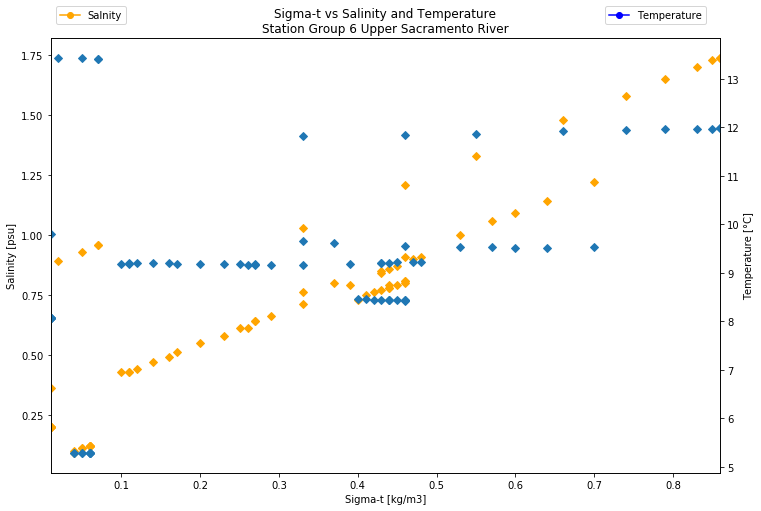

In [39]:
# Station group 6
plot_me(6, 'D')

The correlation between salinity and Sigma-t is clear, even in the Sacramento River, where salinity is low.

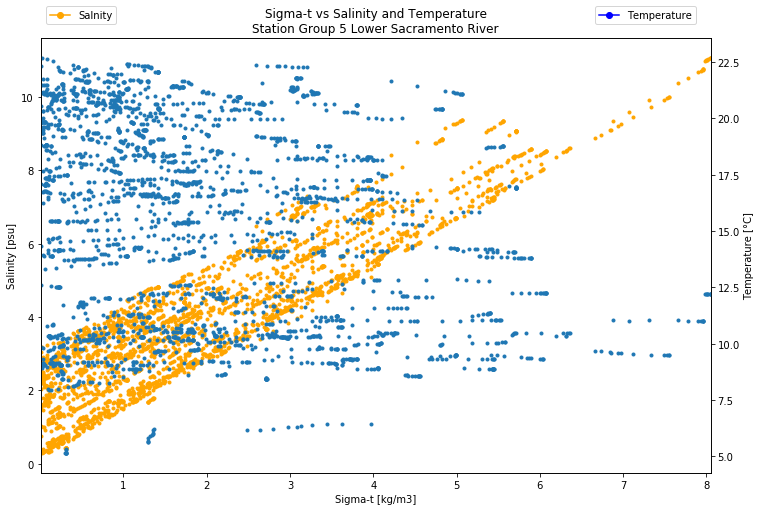

In [40]:
# Station group 5
plot_me(5, '.')

As salinity increases, the . marker becomes too large. Changing to the pixel-size.

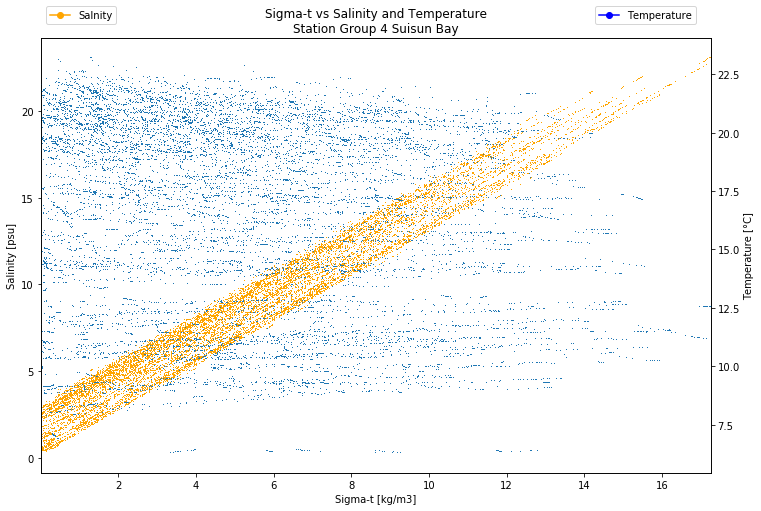

In [41]:
# Station group 4
plot_me(4, ',')

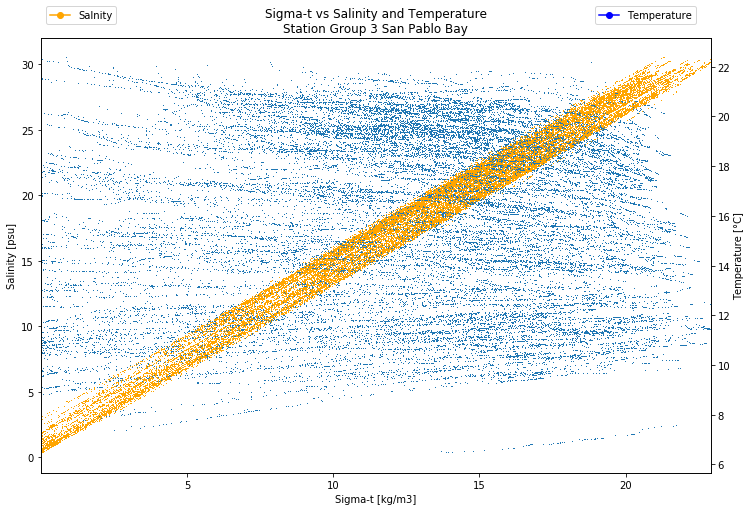

In [42]:
# Station group 3
plot_me(3, ',')

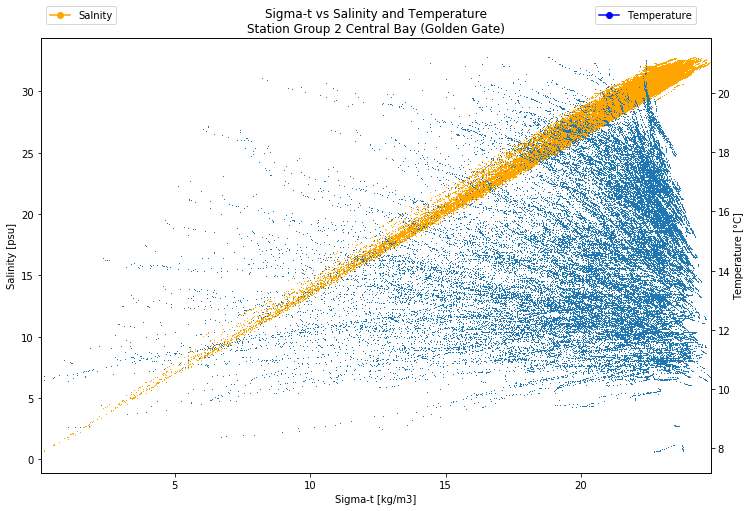

In [43]:
# Station group 2
plot_me(2, ',')

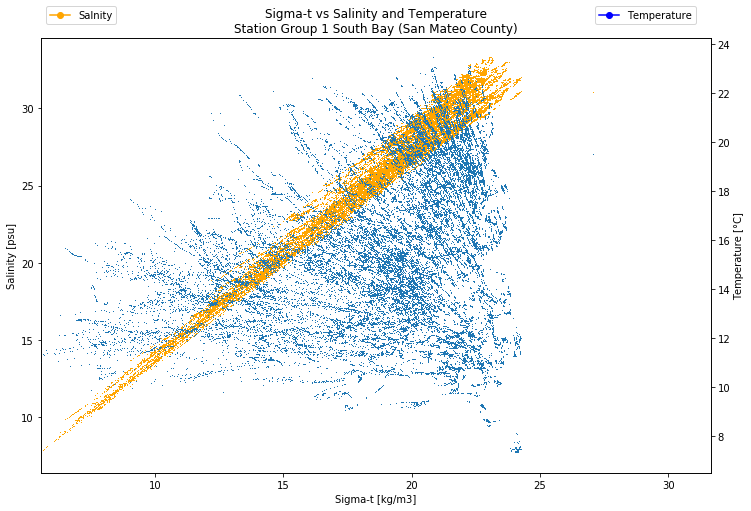

In [44]:
# Station group 1
plot_me(1, ',')

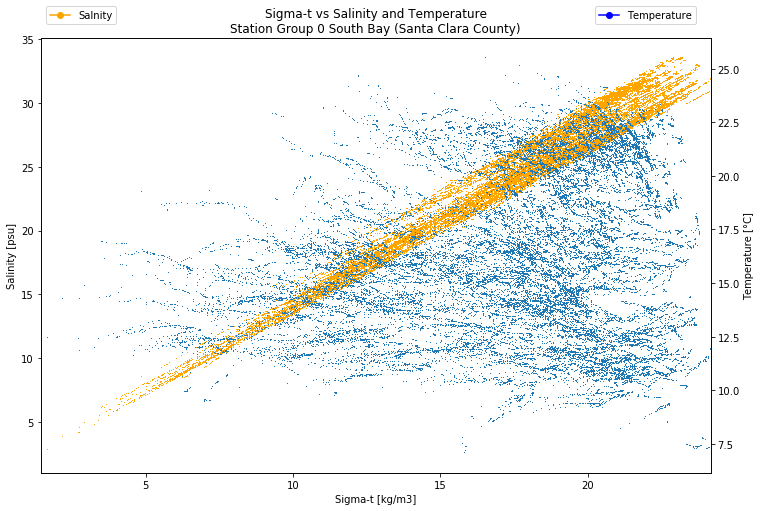

In [45]:
# Station group 0
plot_me(0, ',')

<hr style="border: 3px solid green;">

## Summary

### Mean Salinity 

Null Hypothesis: Mean salinity is essentially the same for the stations nearest the Golden Gate and to the south.

Alternative Hypothesis: Mean salinity differs between the station groups at the Golden Gate, in San Mateo County, and Santa Clara county.

We can reject the null hypothesis and conclude that there is a statistically significant difference in salinity between station groups 0, 1, and 2 - the two South Bay station groups and the Central Bay station group at the Golden Gate.

### Mean Temperature 

Null Hypothesis: Mean temperature is essentially the same for most station groups.

Alternative Hypothesis: Mean temperature differs between station groups.

We can reject the null hypothesis for most station groups. However, we can conclude that the mean temperature between station groups 1 and 3 (South Bay (San Mateo County), just south of the Central Bay, and San Pablo Bay, just north of the Central Bay) are not significantly different.

### Correlations

I found small positive correlations between phyoplankton biovolume vs. chlorophyll (Pearsons correlation: 0.481) and biovolume vs. oxygen (Pearsons correlation: 0.333). Testing nutrients, I found a small negative correlation between biovolume and silicate (Pearsons correlation: -0.308).

The only strong (positive) correlation found is between salinity and Sigma-t, (Pearsons correlation: 0.993). This is expected, given the definition of Sigma-t. The correlation between salinity and Sigma-t is clear, even in the Sacramento River, where salinity is low.

I could not, however, find a strong negative correlation between temperature and Sigma-t. Perhaps the Bay never gets cold enough to show this.

No other correlations were considered worth reporting.


